In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
df = pd.read_csv("health_monitoring.csv")

# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Sort the data by Timestamp
df = df.sort_values(by='Timestamp')

# Split Blood Pressure into Systolic and Diastolic
df[['Systolic BP', 'Diastolic BP']] = df['Blood Pressure'].str.extract(r'(\d+)/(\d+)').astype(float)

# Select only numerical columns for model input
features = ['Heart Rate', 'Systolic BP', 'Diastolic BP', 'Glucose Levels', 'Oxygen Saturation (SpO₂%)']
df_numeric = df[features]

# Normalize using Min-Max Scaling
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df_numeric)

# Create a DataFrame from normalized data
df_normalized = pd.DataFrame(normalized_data, columns=features)

# Show the normalized data
print(df_normalized.head())



   Heart Rate  Systolic BP  Diastolic BP  Glucose Levels  \
0    0.983333        0.600      0.333333          0.7250   
1    0.633333        0.875      0.133333          0.2250   
2    0.250000        0.800      1.000000          0.0625   
3    0.866667        0.750      0.400000          0.4875   
4    0.116667        0.700      0.500000          0.0250   

   Oxygen Saturation (SpO₂%)  
0                        0.6  
1                        0.6  
2                        0.0  
3                        0.3  
4                        0.6  


In [5]:
# Create a binary target from the original df
df_normalized['Alert'] = df['Alert Triggered (Yes/No)'].map({'Yes': 1, 'No': 0}).values

# Drop Timestamp from the original df before normalization (if you need to keep things aligned)
# or just skip this drop if it wasn't added to df_normalized

# Prepare the time-series data
data = df_normalized.values

sequence_length = 10
X, y = [], []

for i in range(len(data) - sequence_length):
    X.append(data[i:i+sequence_length, :-1])  # exclude 'Alert'
    y.append(data[i+sequence_length, -1])     # target is Alert after the window

X = np.array(X)
y = np.array(y)

print(f"Input shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")


Input shape (X): (9990, 10, 5)
Target shape (y): (9990,)


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define deeper stacked LSTM model
model = Sequential([
    LSTM(128, input_shape=(10, 5), return_sequences=True),
    Dropout(0.4),
    
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    
    Dense(32, activation='relu'),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2)

# Save model
model.save("health_alert_model.h5")


Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7307 - loss: 0.5909 - val_accuracy: 0.7317 - val_loss: 0.5831
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7373 - loss: 0.5827 - val_accuracy: 0.7317 - val_loss: 0.5885
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7338 - loss: 0.5855 - val_accuracy: 0.7317 - val_loss: 0.5821
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7417 - loss: 0.5762 - val_accuracy: 0.7317 - val_loss: 0.5816
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7407 - loss: 0.5773 - val_accuracy: 0.7317 - val_loss: 0.5815
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7449 - loss: 0.5706 - val_accuracy: 0.7317 - val_loss: 0.5825
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7318 - loss: 0.5838 - val_accuracy: 0.7317 - val_loss: 0.5816
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7386 - loss: 0.5766 - v

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7334 - loss: 0.5810 - val_accuracy: 0.7317 - val_loss: 0.5817
Epoch 51/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7335 - loss: 0.5807 - val_accuracy: 0.7317 - val_loss: 0.5817
Epoch 52/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7377 - loss: 0.5763 - val_accuracy: 0.7317 - val_loss: 0.5816
Epoch 53/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7343 - loss: 0.5795 - val_accuracy: 0.7317 - val_loss: 0.5815
Epoch 54/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7450 - loss: 0.5679 - val_accuracy: 0.7317 - val_loss: 0.5816
Epoch 55/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7305 - loss: 0.5828 - val_accuracy: 0.7317 - val_loss: 0.5816
Epoch 56/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7441 - loss: 0.5691 - val_accuracy: 0.7317 - val_loss: 0.5816
Epoch 57/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7335 - loss: 0.5800 - val_acc

Epoch 100/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7409 - loss: 0.5728 - val_accuracy: 0.7317 - val_loss: 0.5815


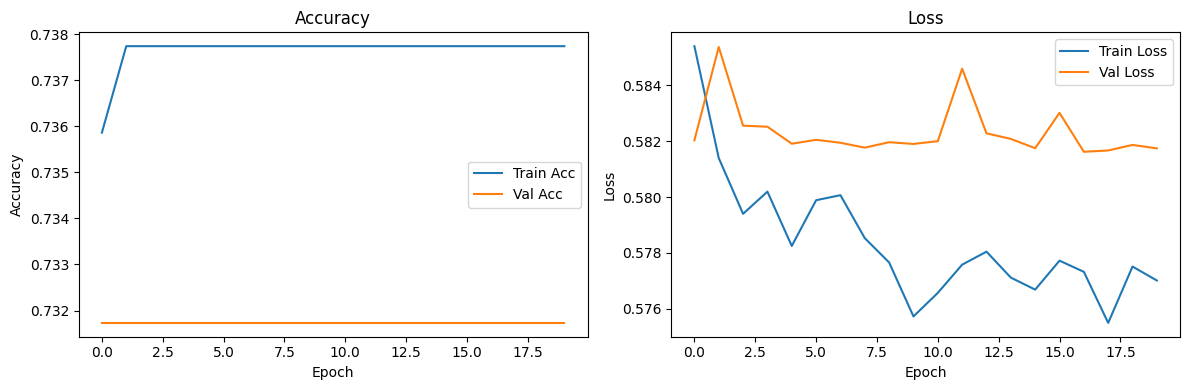

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7368 - loss: 0.5760
Final Accuracy: 0.7365, Loss: 0.5763
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion Matrix:
 [[   0 2632]
 [   0 7358]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2632
         1.0       0.74      1.00      0.85      7358

    accuracy                           0.74      9990
   macro avg       0.37      0.50      0.42      9990
weighted avg       0.54      0.74      0.62      9990



C:\Users\sunil\jupiter_tensorflow\tensorflow_personal\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sunil\jupiter_tensorflow\tensorflow_personal\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sunil\jupiter_tensorflow\tensorflow_personal\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [12]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on full set (or split test set if available)
loss, accuracy = model.evaluate(X, y)
print(f"Final Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predictions
y_pred = model.predict(X) > 0.5

# Confusion matrix
cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
print("\nClassification Report:\n", classification_report(y, y_pred))
